In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import bokeh.io
import bokeh.plotting
import holoviews as hv 
import hvplot
import hvplot.pandas
import seaborn as sns 
import matplotlib.pyplot as plt
import colorcet as cc

from umap import UMAP
from umap_helper import *

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import tqdm

hv.extension('bokeh')
bokeh.io.output_notebook()

%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

# Load black magic command for writing w/style


Loading BokehJS ...

### load TnSeq CES data (binary)

In [2]:
#I think I might need to change this bin data to _processed???

In [4]:
path_data = '../../data/standardized_data/'

file_bin = os.path.join(path_data, '/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/result_bin_matrix_2023_02_20_CC_BxD_processed.csv')
df_bin = pd.read_csv(file_bin)

file_lfc = os.path.join(path_data, '/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/result_logfc_matrix_2023_02_20_CC_BxD_processed.csv')
df_lfc = pd.read_csv(file_lfc)

file_qval = os.path.join(path_data, '/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/result_qval_matrix_2023_02_20_CC_BxD_processed.csv')
df_qval = pd.read_csv(file_qval)


How many screens are there? 

In [5]:
len(df_qval.columns)

147

### Keep only genes that have at least one conditional essentiality call in the dataset:

In [6]:
df_bin['sum_CES'] = df_bin.iloc[:,1:].sum(axis = 1)
df_bin_nz = df_bin[df_bin.sum_CES.values >= 1].copy()
df_bin_nz.shape

(1770, 148)

Text(0, 0.5, 'number of genes')

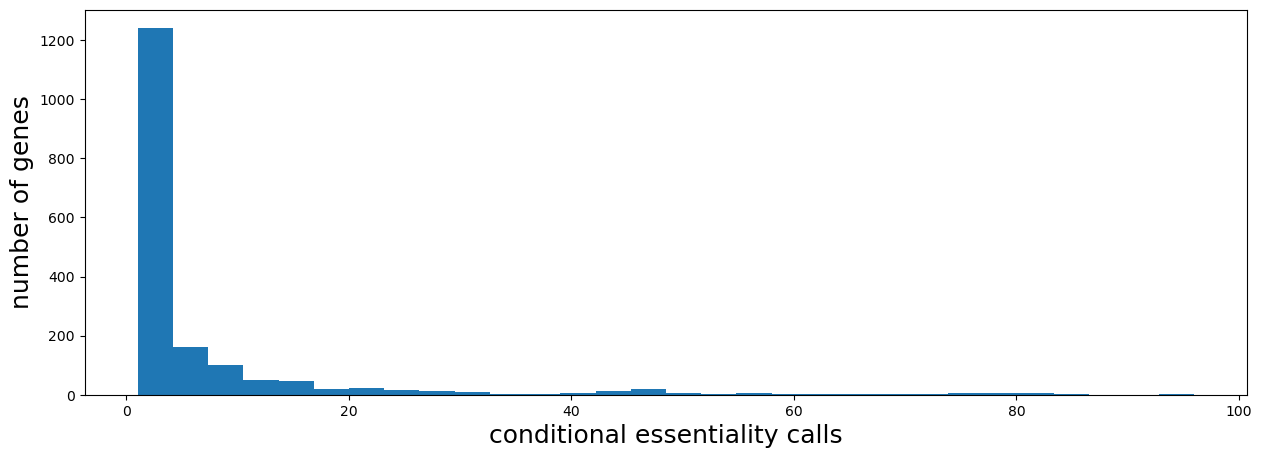

In [7]:
plt.figure(figsize=(15,5))
hst = plt.hist(df_bin_nz.sum_CES, 30)
plt.xlabel('conditional essentiality calls', fontsize = 18)
plt.ylabel('number of genes', fontsize = 18)

### merge with functional annotations: 

In [8]:
#### COG
file_cog = '../../data/annotations/H37Rv_COG_mapping.xlsx'
df_cog_map = pd.read_excel(file_cog)

file_cog_def = '../../data/annotations/cog_names.csv'
df_cog_def = pd.read_csv(file_cog_def)
df_cog_def.rename(columns = {'COG_Desc':'cog_annot'}, inplace = True)

#merge mapping with definitions: 
df_cog_map_def = df_cog_map.merge(df_cog_def, how='left', on = 'COG')
#### Tuberculist
file_tub = '../../data/annotations/H37Rv_tuberculist_functional_categories.xlsx'
df_tub = pd.read_excel(file_tub)
df_tub.rename(columns = {'category':'func_tuberculist'}, inplace = True)

Uniprot annotation data:

In [9]:
file_UP = '../../data/annotations/uniprot_annotation_scores.csv'
df_UP = pd.read_csv(file_UP)
df_UP.head(2)

,Rv_ID,Annotation
0,Rv0001,4
1,Rv0002,4


In [10]:
# Merge with binary matrix:
df_bin_nz_cog = df_bin_nz.merge(df_cog_map, how = 'left', on = 'Rv_ID')
# merge
df_bin_nz_annot = df_bin_nz_cog.merge(df_tub, how = 'left', on = 'Rv_ID')
df_bin_nz_annot = df_bin_nz_annot.merge(df_UP, how = 'left', on = 'Rv_ID')
df_bin_nz_annot = df_bin_nz_annot[['Rv_ID', 'gene_name', 'Annotation', 'func_tuberculist', 'COG'] + list(df_bin_nz.columns[1:])]
df_bin_nz_annot.iloc[:,:6].head(3)

,Rv_ID,gene_name,Annotation,func_tuberculist,COG,PE35_KO_vs_mbio_H37Rv
0,Rv0003,recF,2.0,information pathways,L,0.0
1,Rv0006,gyrA,5.0,information pathways,L,0.0
2,Rv0007,-,1.0,cell wall and cell processes,S,0.0


In [11]:
# Merge with l2fc matrix:
df_lfc_cog = df_lfc.merge(df_cog_map, how = 'left', on = 'Rv_ID')
# merge
df_lfc_annot = df_lfc_cog.merge(df_tub, how = 'left', on = 'Rv_ID')
df_lfc_annot = df_lfc_annot.merge(df_UP, how = 'left', on = 'Rv_ID')

df_lfc_annot = df_lfc_annot[['Rv_ID', 'gene_name', 'Annotation', 'func_tuberculist', 'COG'] + list(df_lfc.columns[1:])]
df_lfc_annot.iloc[:,:6].head(3)

,Rv_ID,gene_name,Annotation,func_tuberculist,COG,PE35_KO_vs_mbio_H37Rv
0,Rv0001,dnaA,4.0,information pathways,L,-0.41
1,Rv0002,dnaN,4.0,information pathways,L,3.28
2,Rv0003,recF,2.0,information pathways,L,-0.03


In [22]:
df_lfc_annot.shape

(4058, 153)

### Tn-Seq UMAP:

In [13]:
# binary data: 
data = df_bin_nz_annot.iloc[:,5:-1]
annot = df_bin_nz_annot.iloc[:,:5]
data_ = data.fillna(data.median())

In [14]:
# l2fc data: 
data_lfc = df_lfc_annot.iloc[:,5:-1]
annot = df_lfc_annot.iloc[:,:5]
data_lfc_ = data_lfc.fillna(data_lfc.median())

#### little PCA test here:

In [15]:
# scaled = StandardScaler().fit_transform(data_)
# projected = PCA(n_components = 25).fit_transform(scaled)

In [16]:
# hv.Points((projected[:, 0], projected[:, 1])).opts(
#     padding=0.1, alpha=0.5, xlabel="PC1", ylabel="PC2", width = 700,
#     height = 300, size = 5)

UMAPs:

In [17]:
# # binary data:
# tnseq_umap = UMAP(min_dist = 0, n_components = 2).fit_transform(data_)
# df_bin_nz_annot['u1'], df_bin_nz_annot['u2'], df_bin_nz_annot['u3'] = tnseq_umap[:, [0,1,2]].T

# binary data:
tnseq_umap = UMAP(min_dist = 0, n_components = 2).fit_transform(data_)
df_bin_nz_annot['u1'], df_bin_nz_annot['u2'], = tnseq_umap[:, [0,1]].T

In [18]:
# binary data:
tnseq_umap_lfc = UMAP(min_dist = 0, n_components = 2).fit_transform(data_lfc_)
df_lfc_annot['u1'], df_lfc_annot['u2'], = tnseq_umap_lfc[:, [0,1]].T

In [19]:
df_lfc_annot.shape

(4058, 153)

In [20]:
file_out = '../../data/standardized_data/df_umap_lfc_08_08_24.csv'
df_lfc_annot.to_csv(file_out, index=False)

#### Repeating with 10 components, to export data for supervised learning: 

In [21]:
df_bin_nz_annot_10 = df_bin_nz_annot.copy()

In [23]:
tnseq_umap_10 = UMAP(min_dist = 0, n_components = 10).fit_transform(data_)

In [24]:
for i in range(10):
    col_name = 'u'+str(i+1)
    df_bin_nz_annot_10[col_name] = tnseq_umap_10[:, [i]]

In [25]:
df_bin_nz_annot_10.shape

(1771, 162)

In [26]:
cols_to_keep = ['Rv_ID', 'gene_name', 'func_tuberculist', 'COG'] + ['u'+str(i) for i in range(1,11)]
df_umap_10 = df_bin_nz_annot_10[cols_to_keep]

In [27]:
file_out = '../../data/df_umap_10.csv'
df_umap_10.to_csv(file_out, index = False)

Done with that bit:

In [28]:
df_bin_nz_annot.hvplot.scatter(
    x = 'u1', 
    y = 'u2', xlabel="UMAP-1", ylabel="UMAP-2",
    hover_cols = ['Rv_ID', 'gene_name', 'COG', 'func_tuberculist'],
    c="Annotation", clabel = 'Annotation',
    alpha = 0.6,
    padding = 0.1,line_color='k', 
    size = 55,
    width = 900,
    height = 400
)

:Scatter   [u1]   (u2,Annotation,Rv_ID,gene_name,COG,func_tuberculist)

In [29]:
df_lfc_annot.hvplot.scatter(
    x = 'u1', 
    y = 'u2', xlabel="UMAP-1", ylabel="UMAP-2",
    hover_cols = ['Rv_ID', 'gene_name', 'COG', 'func_tuberculist'], 
    c="Annotation", clabel = 'Annotation',
    alpha = 0.6,
    padding = 0.1, line_color='k',
    size = 55,
    width = 1200,
    height = 600
)

:Scatter   [u1]   (u2,Annotation,Rv_ID,gene_name,COG,func_tuberculist)

### Clustering using k-means:

Binary data:

In [30]:
cols_to_keep = ['Rv_ID', 'gene_name', 'Annotation', 'func_tuberculist', 'COG','u1', 'u2']
df = df_bin_nz_annot[cols_to_keep].copy()

# file_out = '../../data/tests/df_umap.csv'
# df.to_csv(file_out, index = False)

# data = df[['u1', 'u2', 'u3']].values
data = df[['u1', 'u2']].values

In [31]:
%%time
wcss, sil = choose_k(data, max_clus = 40)

100%|███████████████████████████████████████████| 38/38 [00:04<00:00,  9.13it/s]

CPU times: user 5.36 s, sys: 953 ms, total: 6.31 s
Wall time: 4.17 s


In [32]:
wcss_plot = hv.Curve((wcss), label="Within cluster sum of squares").opts(
    xlabel="number of clusters",
    ylabel="WCSS",
    padding=0.1,
    tools=["hover"],
    color="orange",
)
silhouette_plot = hv.Curve((sil), label="silhouette score").opts(
    xlabel="number of clusters", ylabel="silhouette score", padding=0.1, tools=["hover"]
)
wcss_plot + silhouette_plot.opts(shared_axes = False)

:Layout
   .Curve.Within_cluster_sum_of_squares :Curve   [x]   (y)
   .Curve.Silhouette_score              :Curve   [x]   (y)

In [33]:
seed = 43
np.random.seed(seed)
clustering = KMeans(n_clusters = 21, random_state = seed).fit(data)

cluster_labels = clustering.labels_
df['cluster_labels'] = cluster_labels

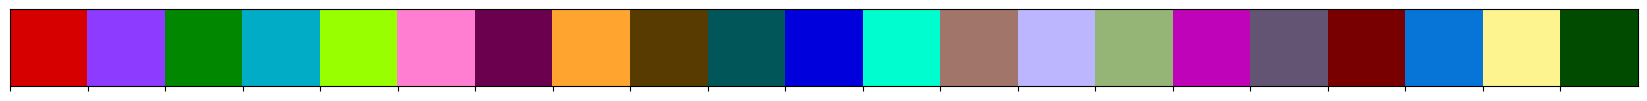

In [34]:
sns.palplot(cc.glasbey[:21])

In [35]:
scatt = df.hvplot.scatter(
    x = 'u1', 
    y = 'u2', 
    c = 'cluster_labels',
    hover_cols = ['Rv_ID', 'gene_name', 'COG', 'func_tuberculist'],
    padding = 0.2, 
    cmap = cc.glasbey[:26], 
    width = 1000, 
    height = 600,
    size = 100,
    alpha = 0.5,
    clabel = 'clusters',
    colorbar=False, 
    line_color = 'k',
    xlabel = 'UMAP-1', ylabel = 'UMAP-2'
).opts(fontsize={'labels': 20, 'xticks': 12, 'yticks': 12})

scatt

:Scatter   [u1]   (u2,cluster_labels,Rv_ID,gene_name,COG,func_tuberculist)

In [36]:
num_clusters = df['cluster_labels'].nunique()
print(f"Number of clusters: {num_clusters}")
cluster_labels.shape

Number of clusters: 21


(1771,)

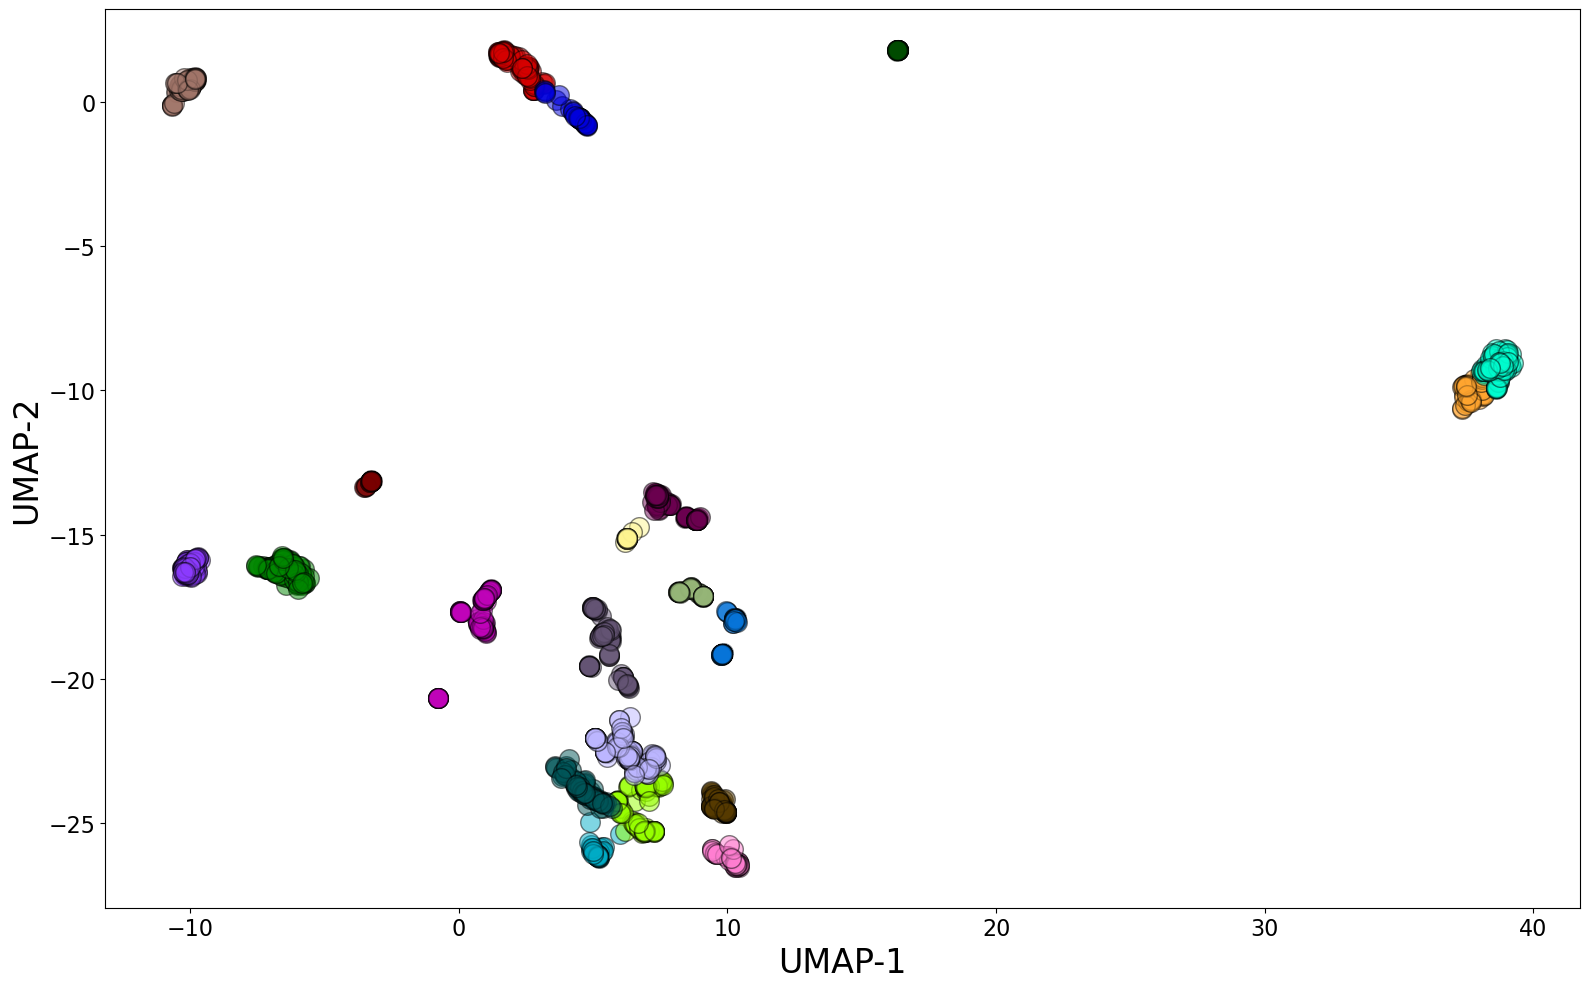

In [59]:
# Assuming 'df' is your DataFrame and 'cluster_labels' is a column in 'df'
plt.figure(figsize=(16,10))
counter = 0

for clus in df['cluster_labels'].unique():
    df_clus = df[df['cluster_labels'] == clus]
    plt.scatter(df_clus.u1, df_clus.u2, s=200, color=cc.glasbey[counter], edgecolors='k', alpha=0.5)
    counter += 1

plt.xlabel('UMAP-1', fontsize=24)
plt.ylabel('UMAP-2', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
UMAP_image = "bin_UMAP_08_12_24.png"
plt.savefig(UMAP_image, dpi=600)
plt.show()


### Enrichment test:

In [39]:
p_val_cutoff = 1e-4

# First, let's select the genes with COG annotation
df_cog = df[pd.notnull(df.COG)]

df_stat = pd.DataFrame()

for clus in np.arange(max(cluster_labels)): 
    df_tmp = fisher_enrichment_test(
        df_cog, 'COG', cluster = clus , clus_col_name = 'cluster_labels'
    )
    df_stat = pd.concat([df_stat, df_tmp])

df_cog = df_stat[df_stat['pval'].values < p_val_cutoff]

# We can do the same for the tuberculist annotations. 
df_tuberculist = df[pd.notnull(df.func_tuberculist)]

df_stats = pd.DataFrame()

for clus in np.arange(max(cluster_labels)): 
    df_tmp = fisher_enrichment_test(
        df_tuberculist, 'func_tuberculist', cluster = clus , clus_col_name = 'cluster_labels'
    )
    df_stats = pd.concat([df_stats, df_tmp])

df_tb = df_stats[df_stats['pval'].values < p_val_cutoff]

df_stat_test = pd.concat([df_cog, df_tb])

In [40]:
df_stat_test

,categories,pval,cluster,annot
0,E,3.845745e-08,0,COG
1,M,8.456324e-06,2,COG
3,F,3.334387e-05,5,COG
1,Q,1.074630e-08,7,COG
0,L,7.539734e-22,9,COG
0,intermediary metabolism and respiration,5.943579e-09,0,func_tuberculist
0,cell wall and cell processes,7.610415e-06,2,func_tuberculist
0,insertion seqs and phages,4.938491e-25,9,func_tuberculist


In [41]:
# df_stat_test.to_csv('../../data/tests/umap_enrichment.csv', index = False)

### Repeat for logFC data:

In [42]:
cols_to_keep = ['Rv_ID', 'gene_name', 'Annotation', 'func_tuberculist', 'COG','u1', 'u2']
df_lfc = df_lfc_annot[cols_to_keep].copy()

# file_out = '../../data/tests/df_umap.csv'
# df.to_csv(file_out, index = False)

#data_lfc = df_lfc[['u1', 'u2', 'u3']].values

data_lfc = df_lfc[['u1', 'u2']].values

In [43]:
%%time
wcss, sil = choose_k(data_lfc, max_clus = 40)

100%|███████████████████████████████████████████| 38/38 [00:15<00:00,  2.52it/s]

CPU times: user 19.6 s, sys: 3.03 s, total: 22.6 s
Wall time: 15.1 s


In [44]:
wcss_plot = hv.Curve((wcss), label="Within cluster sum of squares").opts(
    xlabel="number of clusters",
    ylabel="WCSS",
    padding=0.1,
    tools=["hover"],
    color="orange",
)
silhouette_plot = hv.Curve((sil), label="silhouette score").opts(
    xlabel="number of clusters", ylabel="silhouette score", padding=0.1, tools=["hover"]
)
wcss_plot + silhouette_plot.opts(shared_axes = False)

:Layout
   .Curve.Within_cluster_sum_of_squares :Curve   [x]   (y)
   .Curve.Silhouette_score              :Curve   [x]   (y)

In [45]:
seed = 43
np.random.seed(seed)
clustering = KMeans(n_clusters = 14, random_state = seed).fit(data_lfc)

cluster_labels = clustering.labels_
df_lfc['cluster_labels'] = cluster_labels

In [46]:
df_lfc.hvplot.scatter(
    x = 'u1', 
    y = 'u2', 
    c = 'cluster_labels',
    hover_cols = ['Rv_ID', 'gene_name', 'COG', 'func_tuberculist'],
    padding = 0.2, 
    cmap = cc.glasbey[:26], 
    width = 1000, 
    height = 600,
    size = 100,
    alpha = 0.5,
    clabel = 'clusters',
    colorbar=False, 
    line_color = 'k',
    xlabel = 'UMAP-1', ylabel = 'UMAP-2'
).opts(fontsize={'labels': 20, 'xticks': 12, 'yticks': 12})

:Scatter   [u1]   (u2,cluster_labels,Rv_ID,gene_name,COG,func_tuberculist)

In [47]:
p_val_cutoff = 1e-4

# First, let's select the genes with COG annotation
df_cog = df_lfc[pd.notnull(df_lfc.COG)].copy()

df_stat = pd.DataFrame()

for clus in np.arange(max(cluster_labels)): 
    df_tmp = fisher_enrichment_test(
        df_cog, 'COG', cluster = clus , clus_col_name = 'cluster_labels'
    )
    df_stat = pd.concat([df_stat, df_tmp])

df_cog = df_stat[df_stat['pval'].values < p_val_cutoff]

# We can do the same for the tuberculist annotations. 
df_tuberculist = df_lfc[pd.notnull(df_lfc.func_tuberculist)].copy()

df_stats = pd.DataFrame()

for clus in np.arange(max(cluster_labels)): 
    df_tmp = fisher_enrichment_test(
        df_tuberculist, 'func_tuberculist', cluster = clus , clus_col_name = 'cluster_labels'
    )
    df_stats = pd.concat([df_stats, df_tmp])

df_tb = df_stats[df_stats['pval'].values < p_val_cutoff]

df_stat_test = pd.concat([df_cog, df_tb])

In [48]:
df_stat_test

,categories,pval,cluster,annot
0,S,2.167003e-06,0,COG
1,F,5.737182e-05,5,COG
0,L,9.983360e-36,7,COG
0,J,2.827710e-21,9,COG
1,E,2.280813e-08,9,COG
4,F,9.882146e-08,9,COG
1,J,3.655477e-07,10,COG
0,conserved hypotheticals,9.300055e-05,0,func_tuberculist
3,PE/PPE,2.550753e-08,1,func_tuberculist
3,"virulence, detoxification, adaptation",2.201214e-05,3,func_tuberculist


### Continue

In [49]:
df_cog_def[df_cog_def.COG=='Q'].cog_annot.values

array(['Secondary metabolites biosynthesis, transport and catabolism '],
      dtype=object)

### What's up with cluster 15 and the IS986 transposase?

In [ ]:
# clus_test = 15
# df_clus = df[cluster_labels == clus_test]
# df_bin_clust = df_bin_nz_annot[df_bin_nz_annot.Rv_ID.isin(df_clus.Rv_ID)]

In [ ]:
cols_screen = df_bin_clust.columns[4:-4]


In [ ]:
dict_hits = {}
for rvid in df_bin_clust.Rv_ID.values:
# rvid = 'Rv0766c'
    list_hits = []
    df_temp = df_bin_clust[df_bin_clust.Rv_ID == rvid].copy()
    for col in cols_screen:
        if df_temp[col].values[0]==1:
            list_hits.append(col)
    dict_hits[rvid] = list_hits


In [ ]:
dict_hits

In [ ]:
df_bin_clust[['Rv_ID', 'func_tuberculist', 'carey_621_vs_carey_rv', 'carey_663_vs_carey_rv','mishra_C3H_vs_mishra_B6','mishra_NOS2_vs_mishra_B6']]

##### Are any of these called essential in the original Mishra screen? Only two of them: 
* Rv0766c
* Rv2479c

In [ ]:
file_SI = '../../data/SI_datasets/2017_Mishra_Sassetti/table_1.xlsx'
df_SI = pd.read_excel(file_SI)
df_SI_clus = df_SI[df_SI.Rv_ID.isin(df_bin_clust.Rv_ID)]
df_SI_clus[ (df_SI_clus['log2(C3HeB/BL6)'].abs()>=1) | (df_SI_clus['log2(NOS2/BL6)'].abs()>=1)]

##### In the standardized datasets?

In [ ]:
df_lfc[df_lfc.Rv_ID.isin(df_bin_clust.Rv_ID)][['Rv_ID', 'mishra_C3H_vs_mishra_B6','mishra_NOS2_vs_mishra_B6']]

In [ ]:
df_qval[df_qval.Rv_ID.isin(df_bin_clust.Rv_ID)][['Rv_ID', 'mishra_C3H_vs_mishra_B6','mishra_NOS2_vs_mishra_B6']]

## Compare to randomized datasets: 

##### L2FC data:

In [50]:
num_iter = 400

list_df_stat_test = []
p_val_cutoff = 1e-4

for ii in range(num_iter):
    if ii%20 == 0:
        print(ii, 'out of', num_iter)
    
    # random shuffling of genes:
    df_shuffle = shuffle_genes(df_lfc)

    # First, let's select the genes with COG annotation
    df_cog = df_shuffle[pd.notnull(df_shuffle.COG)]
    df_stat = pd.DataFrame()
    for clus in np.arange(max(cluster_labels)): 
        df_tmp = fisher_enrichment_test(
            df_cog, 'COG', cluster = clus , clus_col_name = 'cluster_labels'
        )

        df_stat = pd.concat([df_stat, df_tmp])
    df_cog = df_stat[df_stat['pval'].values < p_val_cutoff]

    # We can do the same for the tuberculist annotations. 
    df_tuberculist = df_shuffle[pd.notnull(df_shuffle.func_tuberculist)]

    df_stats = pd.DataFrame()

    for clus in np.arange(max(cluster_labels)): 
        df_tmp = fisher_enrichment_test(
            df_tuberculist, 'func_tuberculist', cluster = clus , clus_col_name = 'cluster_labels'
        )

        df_stats = pd.concat([df_stats, df_tmp])

    df_tb = df_stats[df_stats['pval'].values < p_val_cutoff]

    df_stat_test = pd.concat([df_cog, df_tb])
    
    list_df_stat_test.append(df_stat_test)

0 out of 400
20 out of 400
40 out of 400
60 out of 400
80 out of 400
100 out of 400
120 out of 400
140 out of 400
160 out of 400
180 out of 400
200 out of 400
220 out of 400
240 out of 400
260 out of 400
280 out of 400
300 out of 400
320 out of 400
340 out of 400
360 out of 400
380 out of 400


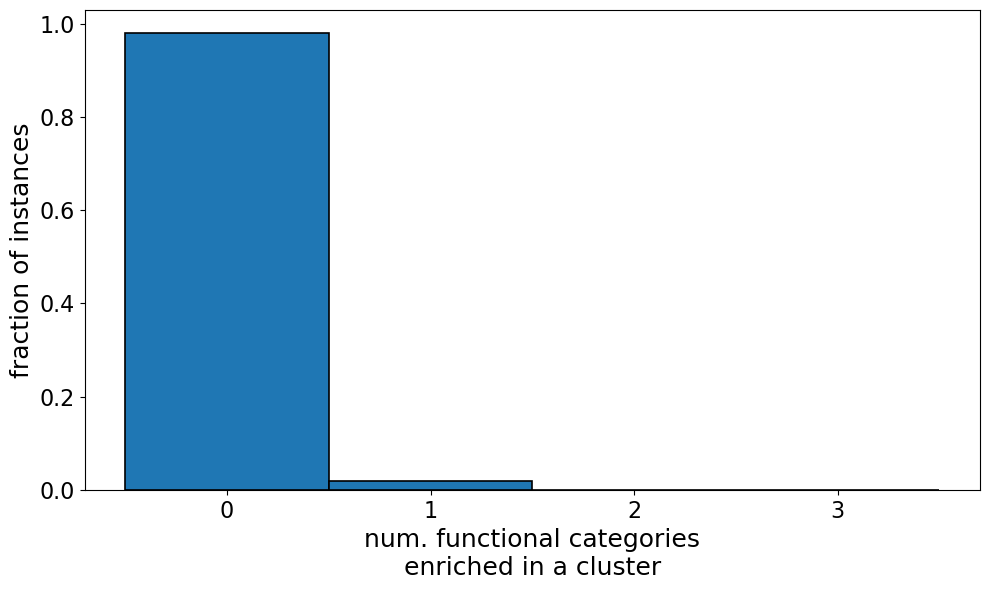

In [51]:
list_num_sig_clust = [df_st.shape[0] for df_st in list_df_stat_test]
plt.figure(figsize=(10,6))
hst = plt.hist(list_num_sig_clust, bins = np.arange(-0.5, 4.5, 1), edgecolor='black', linewidth=1.2, density=True)
xt = plt.xticks([0, 1, 2, 3])
# plt.xlim(0, 17)
plt.xlabel('num. functional categories\nenriched in a cluster', fontsize = 18)
yl = plt.ylabel('fraction of instances', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
# file_fig = '../../figures/genome_visualizations/UMAP_shuffled_stats.png'
# plt.savefig(file_fig, dpi=300)

In [52]:
len([num for num in list_num_sig_clust if num == 0]) / len(list_num_sig_clust)

0.98

##### Binary data:

In [53]:
df_shuffled = shuffle_genes(df)

In [54]:
num_iter = 200
list_df_stat_test = []
p_val_cutoff = 1e-4

for ii in range(num_iter):
    if ii%20 == 0:
        print(ii, 'out of', num_iter)
    
    # random shuffling of genes:
    df_shuffle = shuffle_genes(df)

    # First, let's select the genes with COG annotation
    df_cog = df_shuffle[pd.notnull(df_shuffle.COG)]
    df_stat = pd.DataFrame()
    for clus in np.arange(max(cluster_labels)): 
        df_tmp = fisher_enrichment_test(
            df_cog, 'COG', cluster = clus , clus_col_name = 'cluster_labels'
        )

        df_stat = pd.concat([df_stat, df_tmp])
    df_cog = df_stat[df_stat['pval'].values < p_val_cutoff]

    # We can do the same for the tuberculist annotations. 
    df_tuberculist = df_shuffle[pd.notnull(df_shuffle.func_tuberculist)]

    df_stats = pd.DataFrame()

    for clus in np.arange(max(cluster_labels)): 
        df_tmp = fisher_enrichment_test(
            df_tuberculist, 'func_tuberculist', cluster = clus , clus_col_name = 'cluster_labels'
        )

        df_stats = pd.concat([df_stats, df_tmp])

    df_tb = df_stats[df_stats['pval'].values < p_val_cutoff]

    df_stat_test = pd.concat([df_cog, df_tb])
    
    list_df_stat_test.append(df_stat_test)

0 out of 200
20 out of 200
40 out of 200
60 out of 200
80 out of 200
100 out of 200
120 out of 200
140 out of 200
160 out of 200
180 out of 200


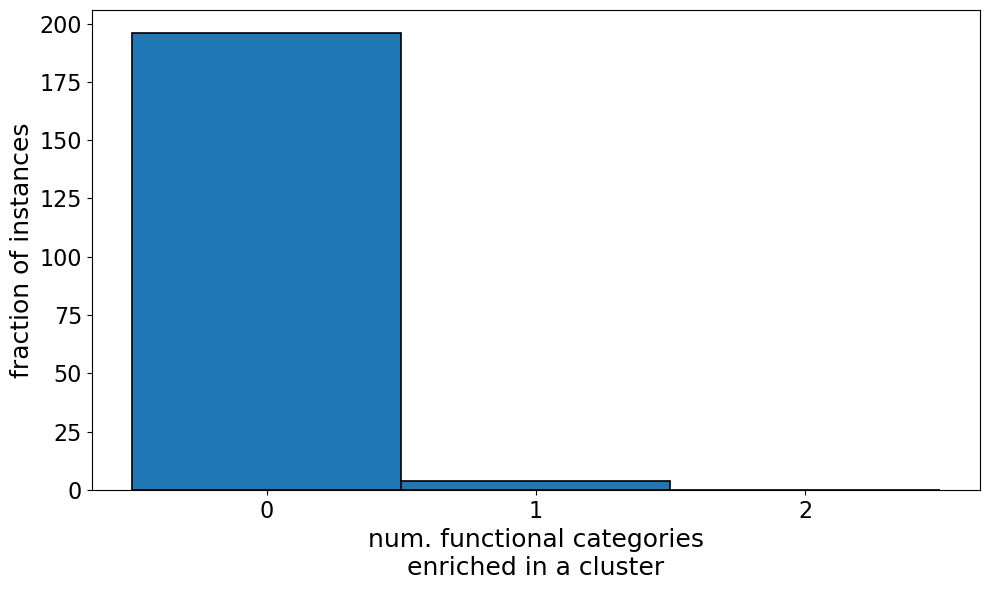

In [55]:
list_num_sig_clust = [df_st.shape[0] for df_st in list_df_stat_test]
plt.figure(figsize=(10,6))
hst = plt.hist(list_num_sig_clust, bins = np.arange(-0.5, 3.5, 1), edgecolor='black', linewidth=1.2, density=False)
# sns.distplot(list_num_sig_clust, bins = np.arange(-0.5, 3.5, 1), kde = False, hist_kws = {'edgecolor':'k', 'linewidth':1.2})
xt = plt.xticks([0, 1, 2])
plt.xlabel('num. functional categories\nenriched in a cluster', fontsize = 18)
yl = plt.ylabel('fraction of instances', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
file_fig = '../../figures/genome_visualizations/UMAP_shuffled_stats.png'
plt.savefig(file_fig, dpi=300)

In [56]:
len([num for num in list_num_sig_clust if num == 0]) / len(list_num_sig_clust)

0.98